In [1]:
import random
import numpy as np 
import pandas as pd 
import datetime
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2
import tensorflow as tf
from PIL import Image
import os
from sklearn.model_selection import train_test_split
from keras import backend as K
from keras.utils import to_categorical, plot_model
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import accuracy_score
from IPython.display import clear_output, HTML

from google.colab import drive
drive.mount("/content/drive")

tf.compat.v1.enable_eager_execution()

# Function to decode the predictions of a model
def decode_predictions(predictions):
  max_elem = np.max(predictions)
  result = np.where(predictions == max_elem)

  df = pd.read_csv(os.path.join('drive','My Drive','TFG','dataset','signnames.csv'))

  index = 4*result[0][0] + result[1][0]

  return df["SignName"][index]

Mounted at /content/drive


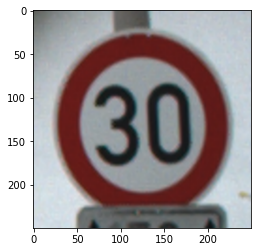

In [35]:
im = Image.open(os.path.join('drive','My Drive','TFG','dataset','Test','00284.png'))
im = im.resize((250,250))
im = np.array(im)
im = im.reshape([1, im.shape[0], im.shape[1], im.shape[2]])

network = os.path.join('drive','My Drive','TFG','models','1','model.h5')

model = load_model(network)

plt.imshow(im[0])

In [36]:
last_conv_layer = model.get_layer("conv2d_7")
last_conv_layer_model = tf.keras.Model(model.inputs, last_conv_layer.output)

classifier_input = tf.keras.Input(shape=last_conv_layer.output.shape[1:])
x = classifier_input

classifier_layer_names = [
    "max_pooling2d_3",
    "flatten_1"
]

for layer_name in classifier_layer_names:
    x = model.get_layer(layer_name)(x)
classifier_model = tf.keras.Model(classifier_input, x)


with tf.GradientTape() as tape:
    inputs = im
    last_conv_layer_output = last_conv_layer_model(inputs)
    tape.watch(last_conv_layer_output)
    preds = classifier_model(last_conv_layer_output)
    top_pred_index = tf.argmax(preds[0])
    top_class_channel = preds[:, top_pred_index]

grads = tape.gradient(top_class_channel, last_conv_layer_output)
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

last_conv_layer_output = last_conv_layer_output.numpy()[0]
pooled_grads = pooled_grads.numpy()
for i in range(pooled_grads.shape[-1]):
    last_conv_layer_output[:, :, i] *= pooled_grads[i]

# Average over all the filters to get a single 2D array
gradcam = np.mean(last_conv_layer_output, axis=-1)
# Clip the values (equivalent to applying ReLU)
# and then normalise the values
gradcam = np.clip(gradcam, 0, np.max(gradcam)) / np.max(gradcam)
gradcam = cv2.resize(gradcam, (250, 250))

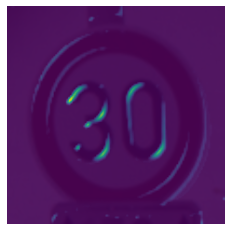

In [37]:
plt.axis(False)
plt.imshow(im[0])
plt.imshow(gradcam, alpha=0.9)

plt.savefig(os.path.join('drive','My Drive','TFG','attacks','gradcam','original.png'), bbox_inches = 'tight', pad_inches = 0)

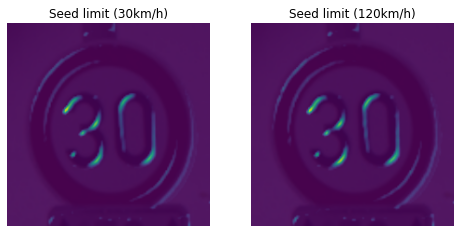

In [38]:
im1 = np.array(Image.open(os.path.join('drive','My Drive','TFG','attacks','gradcam','original.png')))
im2 = np.array(Image.open(os.path.join('drive','My Drive','TFG','attacks','gradcam','attack1.png')))

# Show original image and hacked
fig=plt.figure(figsize=(8, 16))

fig.add_subplot(1, 2, 1)
plt.axis('off')
plt.title('Seed limit (30km/h)')
plt.imshow(im1)

fig.add_subplot(1, 2, 2)
plt.axis('off')
plt.title('Seed limit (120km/h)')
plt.imshow(im2)
      
plt.show()